# Unit14 模型比較 | Model Comparison

**逢甲大學 化學工程學系**  
**課程名稱**: AI在化工上之應用  
**課程代碼**: CHE-AI-114  
**授課教師**: 莊曜禎 助理教授

---

## 📚 學習目標

本程式演練將帶領您完成完整的模型比較流程，包含：

1. **多模型訓練**: 同時訓練 Unit10-13 學習的多種模型
2. **綜合評估**: 使用多種評估指標進行系統化比較
3. **診斷分析**: 繪製學習曲線與驗證曲線，診斷過擬合/欠擬合
4. **統計檢定**: 交叉驗證結果的統計分析與視覺化
5. **模型選擇**: 根據評估結果選出最佳模型

## 📋 案例背景

**場景**: 化學反應器產率預測

**問題描述**:
- 輸入變數: 反應溫度、壓力、催化劑負載量、停留時間、進料濃度等
- 輸出變數: 反應產率 (%)
- 目標: 建立準確的預測模型，協助優化操作條件

**數據集**: 模擬的反應器操作數據 (1000 筆)

**挑戰**:
- 需要從多種模型中選出最適合的
- 需要平衡準確度、訓練時間、可解釋性
- 需要確保模型泛化能力

---

---
## 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P3_Unit14_Model_Comparison'
SOURCE_DATA_DIR = 'reactor_simulation'

try:
    from google.colab import drive
    IN_COLAB = True
    print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
    drive.mount('/content/drive', force_remount=True)
except ImportError:
    IN_COLAB = False
    print("✓ 偵測到 Local 環境")

try:
    shortcut_path = '/content/CHE-AI-COURSE'
    os.remove(shortcut_path)
except FileNotFoundError:
    pass

if IN_COLAB:
    source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
    os.symlink(source_path, shortcut_path)
    shortcut_path = Path(shortcut_path)
    if source_path.exists():
        NOTEBOOK_DIR = shortcut_path / 'Part_3' / 'Unit14'
        OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
        DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
        MODEL_DIR = OUTPUT_DIR / 'models'
        FIG_DIR = OUTPUT_DIR / 'figs'
    else:
        print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
else:
    NOTEBOOK_DIR = Path.cwd()
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\data\reactor_simulation
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Comparison
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Comparison\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Comparison\figs

TensorFlow Version: 2.10.1
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


---
## 1. 載入相關套件

In [2]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')

# Sklearn 模型選擇與評估
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.model_selection import validation_curve, cross_validate, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler

# Unit10: 線性模型
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Unit11: 非線性模型
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# Unit13: 集成學習
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

# 統計檢定
from scipy import stats
from math import pi

# 設定隨機種子
SEED = 42
np.random.seed(SEED)

# 設定視覺化風格
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

print("=" * 60)
print("套件載入完成")
print("=" * 60)
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn 套件: ✓")
print(f"XGBoost: ✓")
print(f"LightGBM: ✓")
print(f"CatBoost: ✓")
print(f"隨機種子設定: {SEED}")
print("=" * 60)

套件載入完成
NumPy version: 1.23.5
Pandas version: 2.3.3
Scikit-learn 套件: ✓
XGBoost: ✓
LightGBM: ✓
CatBoost: ✓
隨機種子設定: 42


---
## 2. 數據生成與探索

In [ ]:
def generate_reactor_data(n_samples=10000, random_state=42):
    """
    生成模擬化學反應器數據（高複雜度版本）
    
    包含複雜非線性關係、多重交互項、週期性效應和異常值
    
    Parameters:
    -----------
    n_samples : int
        樣本數量（默認10000以展現模型差異）
    random_state : int
        隨機種子
    
    Returns:
    --------
    X : DataFrame
        特徵數據
    y : ndarray
        目標變數（產率）
    """
    np.random.seed(random_state)
    
    # 生成特徵
    # 溫度 (Temperature, °C): 50-150
    temperature = np.random.uniform(50, 150, n_samples)
    
    # 壓力 (Pressure, bar): 1-10
    pressure = np.random.uniform(1, 10, n_samples)
    
    # 催化劑負載量 (Catalyst Loading, %): 0.1-5.0
    catalyst_loading = np.random.uniform(0.1, 5.0, n_samples)
    
    # 停留時間 (Residence Time, min): 10-120
    residence_time = np.random.uniform(10, 120, n_samples)
    
    # 進料濃度 (Feed Concentration, mol/L): 0.5-5.0
    feed_concentration = np.random.uniform(0.5, 5.0, n_samples)
    
    # 建立 DataFrame
    X = pd.DataFrame({
        'Temperature': temperature,
        'Pressure': pressure,
        'Catalyst_Loading': catalyst_loading,
        'Residence_Time': residence_time,
        'Feed_Concentration': feed_concentration
    })
    
    # 生成目標變數（產率，%）- 極度複雜的非線性關係
    
    # 1. 基本非線性效應（進一步調整係數）
    # 溫度效應 (Arrhenius-like with optimal point)
    temp_effect = 5 * np.exp((temperature - 100) / 50) - 0.01 * (temperature - 100) ** 2
    
    # 壓力效應 (複雜指數關係)
    pressure_effect = 2 * pressure ** 1.2 + 1 * np.sin(pressure / 2)
    
    # 催化劑效應 (飽和曲線 + 抑制效應)
    catalyst_effect = 12 * (1 - np.exp(-catalyst_loading)) - 1 * catalyst_loading ** 2
    
    # 停留時間效應 (對數增長 + 週期性振盪)
    time_effect = 6 * np.log(residence_time + 1) + 1.5 * np.sin(residence_time / 20)
    
    # 進料濃度效應 (三次多項式)
    conc_effect = (4 * feed_concentration - 1 * feed_concentration ** 2 + 
                   0.08 * feed_concentration ** 3)
    
    # 2. 複雜交互作用（進一步降低係數）
    # 溫度-壓力交互 (非線性)
    temp_pressure_interact = 0.03 * temperature * np.log(pressure + 1)
    
    # 催化劑-停留時間交互 (飽和曲線)
    catalyst_time_interact = 0.08 * catalyst_loading * np.sqrt(residence_time)
    
    # 三元交互 (溫度-催化劑-濃度)
    triple_interact = 0.002 * temperature * catalyst_loading * feed_concentration
    
    # 壓力-濃度交互 (拋物線)
    pressure_conc_interact = 0.3 * pressure * feed_concentration - 0.03 * pressure * feed_concentration ** 2
    
    # 3. 高階非線性項（進一步降低係數）
    # 溫度的三角函數效應（模擬週期性反應機制）
    temp_periodic = 2 * np.sin((temperature - 50) / 30) * np.cos((temperature - 50) / 40)
    
    # 指數衰減項（模擬催化劑失活）
    deactivation = -1.5 * np.exp(-(catalyst_loading + residence_time / 50))
    
    # 對數交互項
    log_interact = 1 * np.log(1 + catalyst_loading) * np.log(1 + pressure)
    
    # 4. 組合所有效應（進一步降低基線）
    yield_rate = (
        temp_effect + 
        pressure_effect + 
        catalyst_effect + 
        time_effect + 
        conc_effect +
        temp_pressure_interact +
        catalyst_time_interact +
        triple_interact +
        pressure_conc_interact +
        temp_periodic +
        deactivation +
        log_interact -
        5  # 基線偏移調整為負值
    )
    
    # 5. 添加不同類型的噪聲
    # 主要噪聲（正態分佈）
    main_noise = np.random.normal(0, 4.0, n_samples)
    
    # 異質性噪聲（與溫度相關）
    hetero_noise = np.random.normal(0, 0.02 * temperature, n_samples)
    
    # 添加約2%的異常值
    n_outliers = int(0.02 * n_samples)
    outlier_idx = np.random.choice(n_samples, n_outliers, replace=False)
    outlier_noise = np.zeros(n_samples)
    outlier_noise[outlier_idx] = np.random.uniform(-25, 25, n_outliers)
    
    # 總噪聲
    total_noise = main_noise + hetero_noise + outlier_noise
    
    yield_rate += total_noise
    
    # 限制產率在 0-100% 範圍內（現在應該大部分數據自然落在範圍內）
    y = np.clip(yield_rate, 0, 100)
    
    return X, y

# 生成模擬數據（高複雜度版本，10000樣本）
X, y = generate_reactor_data(n_samples=10000, random_state=42)

print("=" * 60)
print("Data Generation Summary")
print("=" * 60)
print(f"Total samples: {len(X)}")
print(f"Number of features: {X.shape[1]}")
print(f"\nFeature names: {list(X.columns)}")
print(f"\nTarget variable (Yield) statistics:")
print(f"  Mean: {y.mean():.2f}%")
print(f"  Std: {y.std():.2f}%")
print(f"  Min: {y.min():.2f}%")
print(f"  Max: {y.max():.2f}%")
print(f"  Median: {np.median(y):.2f}%")
print(f"\n  Clipped to 100: {(y == 100).sum()} samples ({(y == 100).sum()/len(y)*100:.2f}%)")
print(f"  Clipped to 0: {(y == 0).sum()} samples ({(y == 0).sum()/len(y)*100:.2f}%)")
print(f"\n✅ Data distribution is {'natural' if (y == 100).sum()/len(y) < 0.05 else 'affected by clipping'}")
print("=" * 60)

Data Generation Summary
Total samples: 10000
Number of features: 5

Feature names: ['Temperature', 'Pressure', 'Catalyst_Loading', 'Residence_Time', 'Feed_Concentration']

Target variable (Yield) statistics:
  Mean: 52.49%
  Std: 15.96%
  Min: 0.00%
  Max: 100.00%
  Median: 52.79%

  Clipped to 100: 5 samples (0.05%)
  Clipped to 0: 3 samples (0.03%)

✅ Data distribution is natural



✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Comparison\figs\01_data_distribution.png


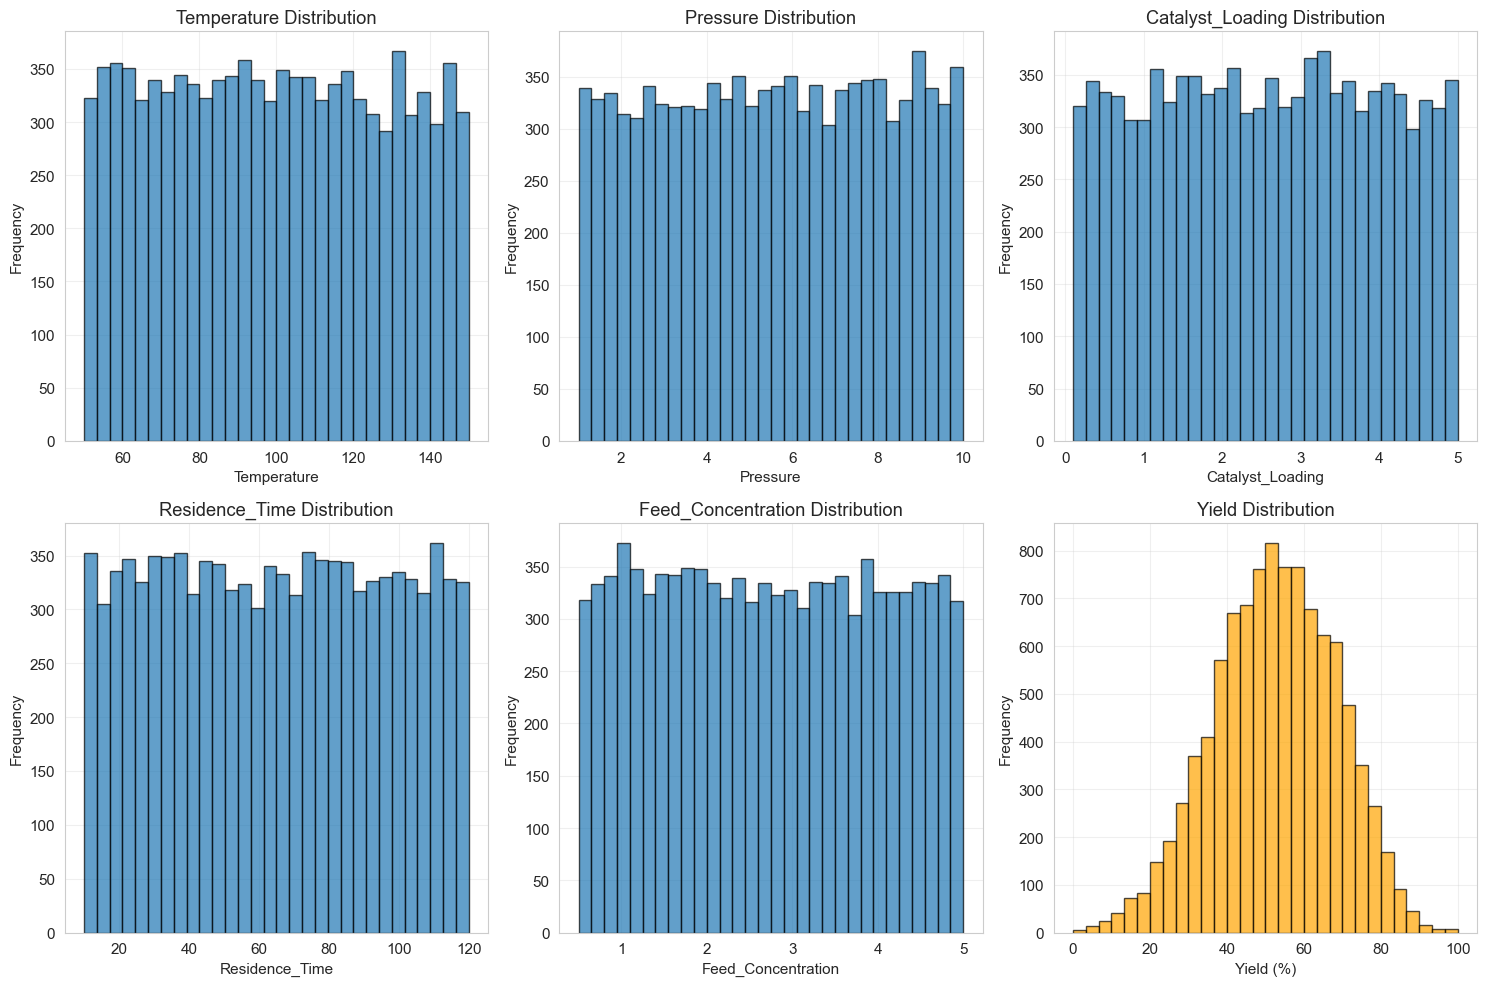

In [4]:
# 數據可視化
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

# 特徵分布
for i, col in enumerate(X.columns):
    axes[i].hist(X[col], bins=30, edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True, alpha=0.3)

# 目標變數分布
axes[5].hist(y, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[5].set_title('Yield Distribution')
axes[5].set_xlabel('Yield (%)')
axes[5].set_ylabel('Frequency')
axes[5].grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIG_DIR / '01_data_distribution.png', dpi=300, bbox_inches='tight')
print(f"\n✓ 圖片已儲存: {FIG_DIR / '01_data_distribution.png'}")
plt.show()

---
## 3. 數據分割與預處理

In [5]:
# 分割數據集: 70% 訓練, 15% 驗證, 15% 測試
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42  # 0.176 * 0.85 ≈ 0.15
)

print("=" * 60)
print("Data Split Summary")
print("=" * 60)
print(f"Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print("=" * 60)

Data Split Summary
Training set: 7004 samples (70.0%)
Validation set: 1496 samples (15.0%)
Test set: 1500 samples (15.0%)


In [6]:
# 特徵標準化 (對某些模型如 SVM 很重要)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ 特徵標準化完成")
print(f"Scaled features mean: {X_train_scaled.mean(axis=0)}")
print(f"Scaled features std: {X_train_scaled.std(axis=0)}")

✅ 特徵標準化完成
Scaled features mean: [ 4.10864946e-16 -4.00720132e-17  8.47091925e-17 -2.53620337e-16
 -1.32897057e-16]
Scaled features std: [1. 1. 1. 1. 1.]


---
## 4. 定義模型清單

建立 Unit10-13 學習的所有主要模型。

In [7]:
# 建立模型字典
models = {
    # Unit10: 線性模型
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=0.1, random_state=42),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
    
    # Unit11: 非線性模型
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'SVR': SVR(kernel='rbf', C=100, epsilon=0.1),
    
    # Unit13: 集成學習 (Boosting)
    'XGBoost': xgb.XGBRegressor(
        n_estimators=100, 
        max_depth=5, 
        learning_rate=0.1,
        random_state=42,
        verbosity=0
    ),
    'LightGBM': lgb.LGBMRegressor(
        n_estimators=100, 
        max_depth=5, 
        learning_rate=0.1,
        random_state=42,
        verbose=-1
    ),
    'CatBoost': CatBoostRegressor(
        iterations=100, 
        depth=5, 
        learning_rate=0.1,
        random_state=42,
        verbose=False
    )
}

print("=" * 60)
print("Model List Summary")
print("=" * 60)
print(f"Total models: {len(models)}")
print("\nModel names:")
for i, name in enumerate(models.keys(), 1):
    print(f"  {i}. {name}")
print("=" * 60)

Model List Summary
Total models: 11

Model names:
  1. Linear Regression
  2. Ridge
  3. Lasso
  4. ElasticNet
  5. Decision Tree
  6. Random Forest
  7. Gradient Boosting
  8. SVR
  9. XGBoost
  10. LightGBM
  11. CatBoost


---
## 5. 訓練所有模型並評估

使用訓練集訓練模型，在驗證集上評估性能。

In [8]:
import time

# 儲存結果
results = []

print("=" * 80)
print("Training and Evaluation Progress")
print("=" * 80)

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    # 記錄訓練時間
    start_time = time.time()
    
    # 訓練模型 (根據模型類型選擇是否使用標準化數據)
    if name in ['SVR', 'Ridge', 'Lasso', 'ElasticNet', 'Linear Regression']:
        # 線性模型和 SVM 使用標準化數據
        model.fit(X_train_scaled, y_train)
        y_train_pred = model.predict(X_train_scaled)
        y_val_pred = model.predict(X_val_scaled)
    else:
        # 樹模型不需要標準化
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
    
    training_time = time.time() - start_time
    
    # 計算評估指標
    # 訓練集
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    
    # 驗證集
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
    
    # 計算過擬合程度
    overfit_r2 = train_r2 - val_r2
    
    # 儲存結果
    results.append({
        'Model': name,
        'Train_MAE': train_mae,
        'Train_RMSE': train_rmse,
        'Train_R2': train_r2,
        'Train_MAPE': train_mape,
        'Val_MAE': val_mae,
        'Val_RMSE': val_rmse,
        'Val_R2': val_r2,
        'Val_MAPE': val_mape,
        'Overfit_R2': overfit_r2,
        'Training_Time': training_time
    })
    
    print(f"  ✅ Completed in {training_time:.3f}s")
    print(f"     Validation R²: {val_r2:.4f} | MAE: {val_mae:.3f} | RMSE: {val_rmse:.3f}")

print("\n" + "=" * 80)
print("✅ All models trained successfully!")
print("=" * 80)

Training and Evaluation Progress

🔄 Training Linear Regression...
  ✅ Completed in 0.023s
     Validation R²: 0.6647 | MAE: 7.445 | RMSE: 9.080

🔄 Training Ridge...
  ✅ Completed in 0.008s
     Validation R²: 0.6647 | MAE: 7.445 | RMSE: 9.080

🔄 Training Lasso...
  ✅ Completed in 0.002s
     Validation R²: 0.6646 | MAE: 7.447 | RMSE: 9.082

🔄 Training ElasticNet...
  ✅ Completed in 0.002s
     Validation R²: 0.6632 | MAE: 7.461 | RMSE: 9.101

🔄 Training Decision Tree...
  ✅ Completed in 0.042s
     Validation R²: 0.8042 | MAE: 5.453 | RMSE: 6.938

🔄 Training Random Forest...
  ✅ Completed in 2.545s
     Validation R²: 0.8762 | MAE: 4.355 | RMSE: 5.517

🔄 Training Gradient Boosting...
  ✅ Completed in 2.399s
     Validation R²: 0.8938 | MAE: 3.979 | RMSE: 5.110

🔄 Training SVR...
  ✅ Completed in 11.054s
     Validation R²: 0.8993 | MAE: 3.893 | RMSE: 4.975

🔄 Training XGBoost...
  ✅ Completed in 0.463s
     Validation R²: 0.8935 | MAE: 3.983 | RMSE: 5.118

🔄 Training LightGBM...
  ✅ Co

In [9]:
# 建立結果 DataFrame
results_df = pd.DataFrame(results)

# 依驗證集 R² 排序
results_df = results_df.sort_values('Val_R2', ascending=False).reset_index(drop=True)

# 顯示結果
print("\n" + "=" * 100)
print("Model Comparison Results (Sorted by Validation R²)")
print("=" * 100)
print(results_df.to_string(index=False))
print("=" * 100)


Model Comparison Results (Sorted by Validation R²)
            Model  Train_MAE  Train_RMSE  Train_R2   Train_MAPE  Val_MAE  Val_RMSE   Val_R2  Val_MAPE  Overfit_R2  Training_Time
         CatBoost   3.731608    4.919249  0.906473 2.465310e+13 3.870615  4.974767 0.899358  0.099086    0.007115       0.536906
              SVR   3.550747    4.844253  0.909303 2.493786e+13 3.892765  4.975218 0.899340  0.099052    0.009963      11.054103
         LightGBM   3.299063    4.347119  0.926963 2.088697e+13 3.967119  5.089844 0.894648  0.103456    0.032315       5.407518
Gradient Boosting   3.153651    4.115114  0.934551 1.364757e+13 3.979462  5.109555 0.893831  0.100606    0.040720       2.398703
          XGBoost   3.174330    4.180916  0.932441 1.522962e+13 3.982952  5.118144 0.893474  0.101928    0.038968       0.462569
    Random Forest   3.116865    4.062450  0.936216 1.488705e+13 4.354797  5.516957 0.876226  0.113024    0.059990       2.545130
    Decision Tree   3.451698    4.666583  0.9

---
## 6. 視覺化模型性能比較


✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Comparison\figs\02_r2_score_comparison.png


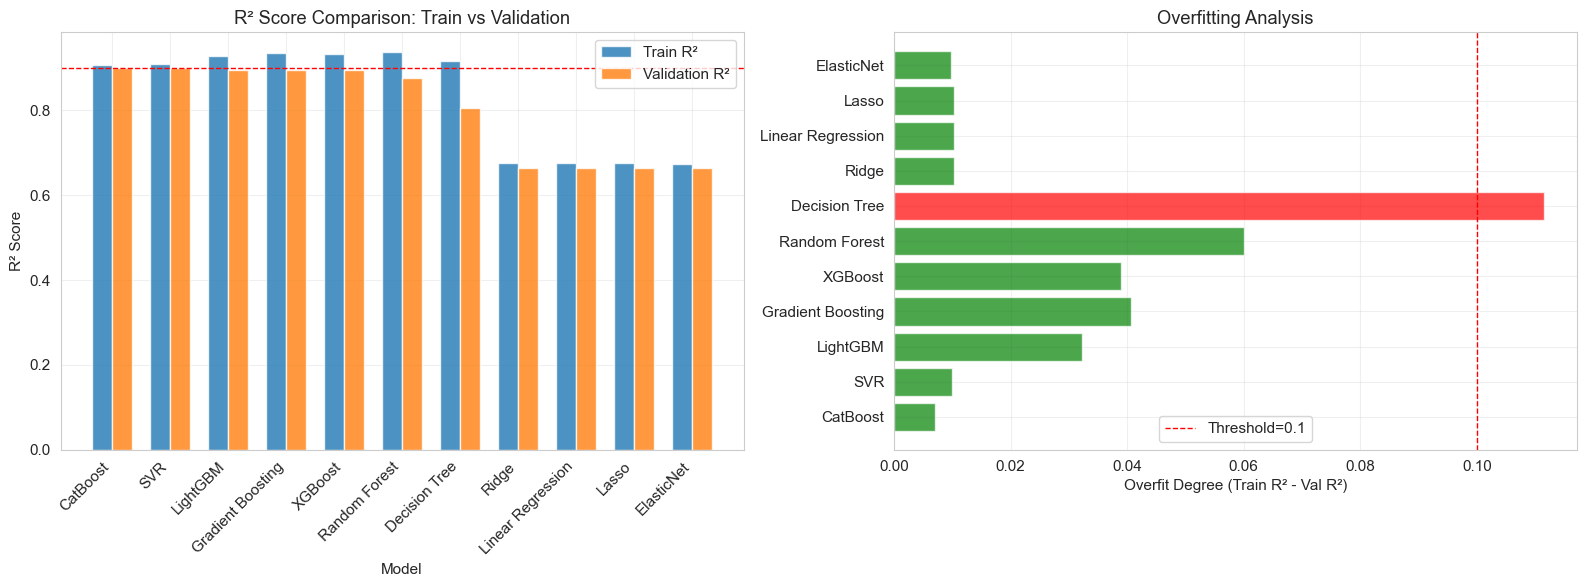


💡 Interpretation:
  - Models with Overfit > 0.1 are overfitting
  - Green bars indicate good generalization
  - Red bars indicate potential overfitting issues


In [10]:
# 6.1 R² Score 比較
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 訓練集 vs 驗證集 R²
x = np.arange(len(results_df))
width = 0.35

axes[0].bar(x - width/2, results_df['Train_R2'], width, label='Train R²', alpha=0.8)
axes[0].bar(x + width/2, results_df['Val_R2'], width, label='Validation R²', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('R² Score')
axes[0].set_title('R² Score Comparison: Train vs Validation')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axhline(y=0.9, color='r', linestyle='--', linewidth=1, label='Target R²=0.9')

# 過擬合程度 (Train R² - Val R²)
colors = ['red' if x > 0.1 else 'green' for x in results_df['Overfit_R2']]
axes[1].barh(results_df['Model'], results_df['Overfit_R2'], color=colors, alpha=0.7)
axes[1].set_xlabel('Overfit Degree (Train R² - Val R²)')
axes[1].set_title('Overfitting Analysis')
axes[1].axvline(x=0.1, color='r', linestyle='--', linewidth=1, label='Threshold=0.1')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIG_DIR / '02_r2_score_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n✓ 圖片已儲存: {FIG_DIR / '02_r2_score_comparison.png'}")
plt.show()

print("\n💡 Interpretation:")
print("  - Models with Overfit > 0.1 are overfitting")
print("  - Green bars indicate good generalization")
print("  - Red bars indicate potential overfitting issues")


✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Comparison\figs\03_mae_rmse_comparison.png


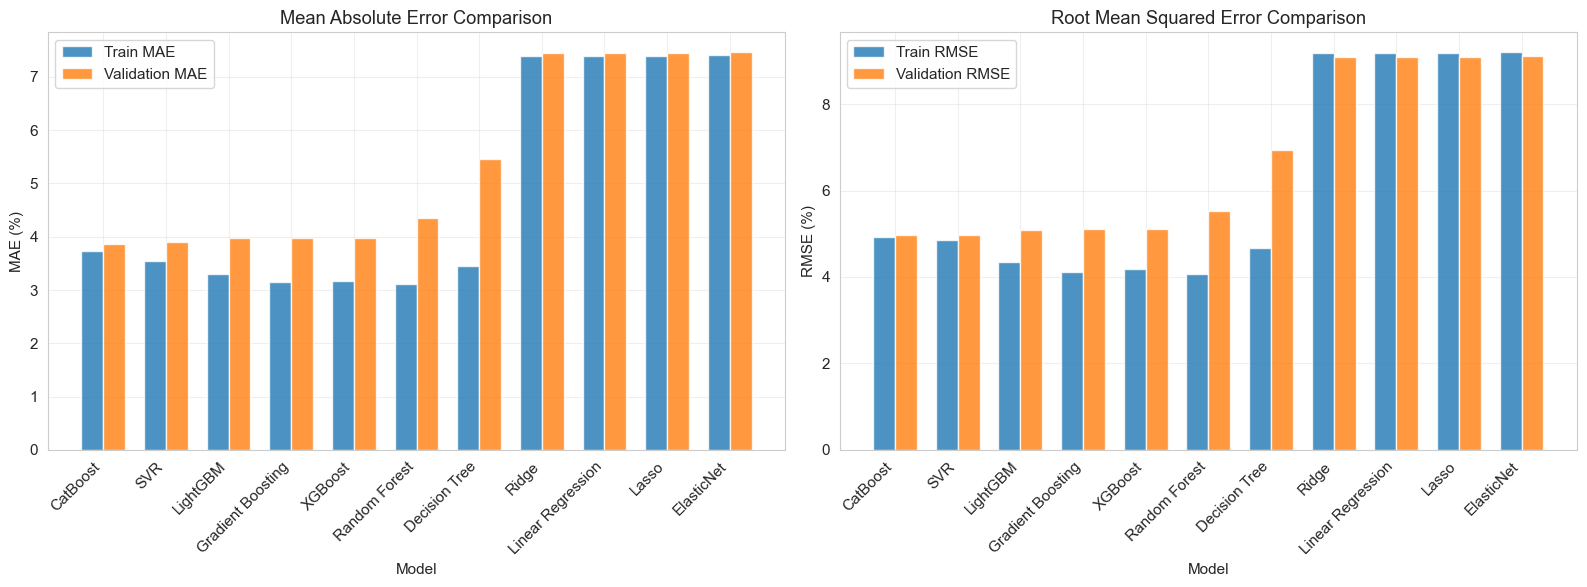


💡 Interpretation:
  - Lower MAE/RMSE indicates better performance
  - RMSE penalizes large errors more than MAE


In [ ]:
# 6.2 MAE 和 RMSE 比較
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MAE 比較
axes[0].bar(x - width/2, results_df['Train_MAE'], width, label='Train MAE', alpha=0.8)
axes[0].bar(x + width/2, results_df['Val_MAE'], width, label='Validation MAE', alpha=0.8)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('MAE (%)')
axes[0].set_title('Mean Absolute Error Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RMSE 比較
axes[1].bar(x - width/2, results_df['Train_RMSE'], width, label='Train RMSE', alpha=0.8)
axes[1].bar(x + width/2, results_df['Val_RMSE'], width, label='Validation RMSE', alpha=0.8)
axes[1].set_xlabel('Model')
axes[1].set_ylabel('RMSE (%)')
axes[1].set_title('Root Mean Squared Error Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIG_DIR / '03_mae_rmse_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n✓ 圖片已儲存: {FIG_DIR / '03_mae_rmse_comparison.png'}")
plt.show()

print("\n💡 Interpretation:")
print("  - Lower MAE/RMSE indicates better performance")
print("  - RMSE penalizes large errors more than MAE")


✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Comparison\figs\04_training_time_comparison.png


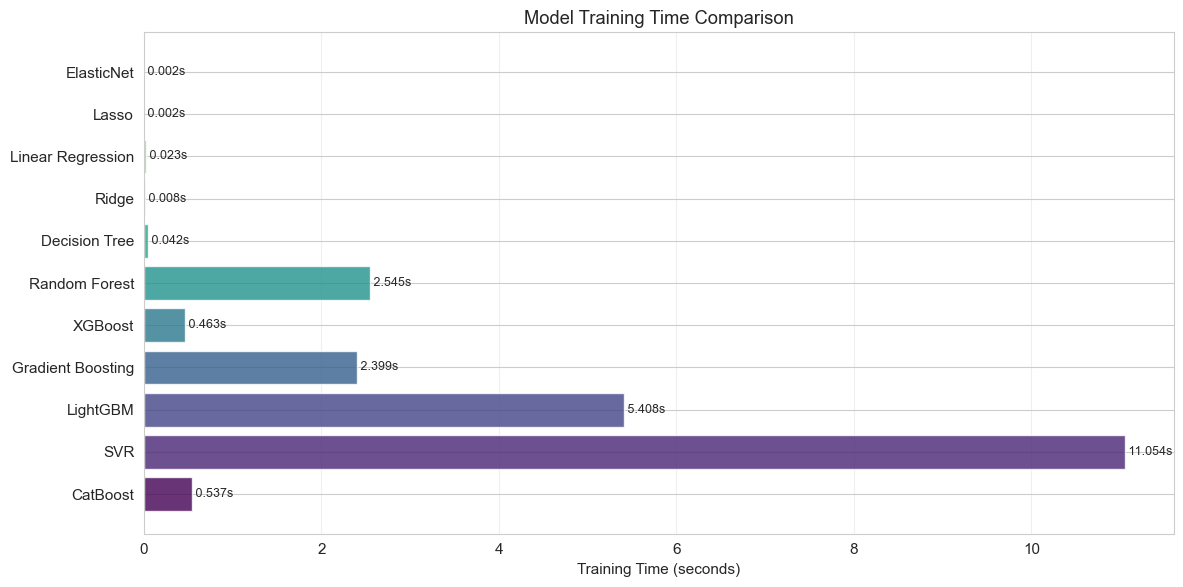


💡 Interpretation:
  - Faster training is better for iterative development
  - Tree-based models typically train faster than boosting models


In [14]:
# 6.3 訓練時間比較
fig, ax = plt.subplots(figsize=(12, 6))

colors_time = plt.cm.viridis(np.linspace(0, 1, len(results_df)))
bars = ax.barh(results_df['Model'], results_df['Training_Time'], color=colors_time, alpha=0.8)

ax.set_xlabel('Training Time (seconds)')
ax.set_title('Model Training Time Comparison')
ax.grid(True, alpha=0.3, axis='x')

# 在每個 bar 上顯示數值
for i, (bar, time) in enumerate(zip(bars, results_df['Training_Time'])):
    ax.text(time, i, f' {time:.3f}s', va='center', fontsize=9)

plt.tight_layout()
fig.savefig(FIG_DIR / '04_training_time_comparison.png', dpi=300, bbox_inches='tight')
print(f"\n✓ 圖片已儲存: {FIG_DIR / '04_training_time_comparison.png'}")
plt.show()

print("\n💡 Interpretation:")
print("  - Faster training is better for iterative development")
print("  - Tree-based models typically train faster than boosting models")


✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Comparison\figs\05_radar_chart_top5.png


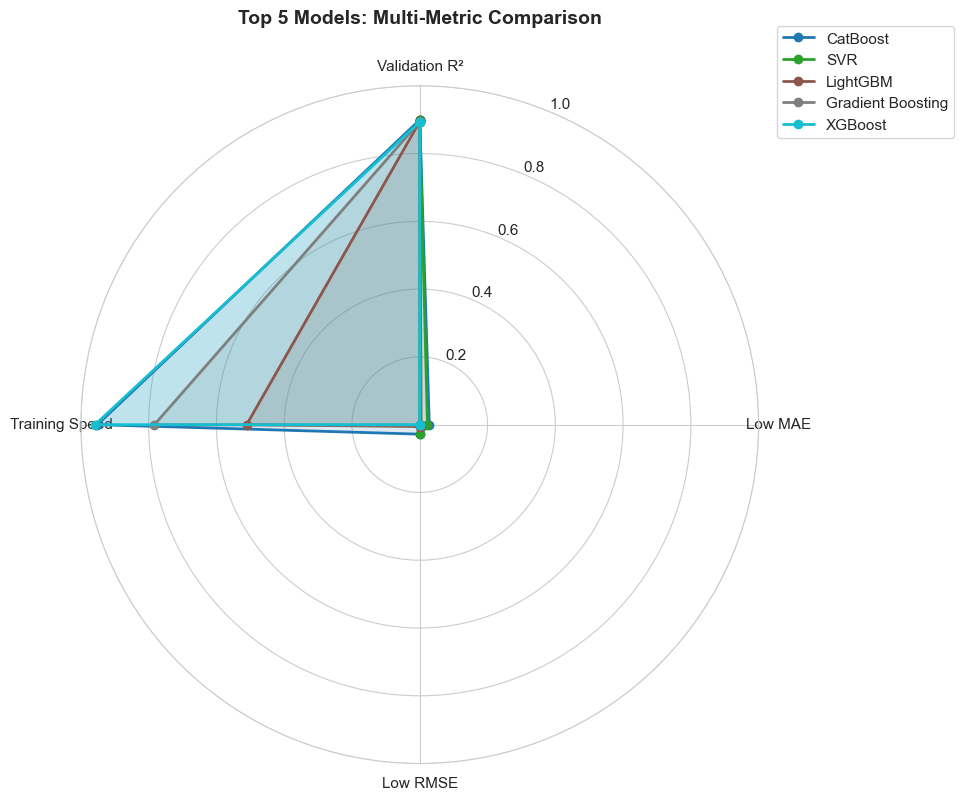


💡 Interpretation:
  - Larger area indicates better overall performance
  - Look for balanced performance across all metrics


In [16]:
# 6.4 多指標雷達圖 (Top 5 models)
from math import pi

# 選擇 Top 5 模型
top5_df = results_df.head(5)

# 準備數據 (正規化到 0-1)
categories = ['Val_R2', 'Val_MAE_inv', 'Val_RMSE_inv', 'Training_Speed']

# 反轉 MAE 和 RMSE (越小越好 -> 越大越好)
data_normalized = pd.DataFrame()
data_normalized['Val_R2'] = top5_df['Val_R2']
data_normalized['Val_MAE_inv'] = 1 - (top5_df['Val_MAE'] / top5_df['Val_MAE'].max())
data_normalized['Val_RMSE_inv'] = 1 - (top5_df['Val_RMSE'] / top5_df['Val_RMSE'].max())
data_normalized['Training_Speed'] = 1 - (top5_df['Training_Time'] / top5_df['Training_Time'].max())

# 繪製雷達圖
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='polar')

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(['Validation R²', 'Low MAE', 'Low RMSE', 'Training Speed'])

colors = plt.cm.tab10(np.linspace(0, 1, len(top5_df)))

for idx, (i, row) in enumerate(top5_df.iterrows()):
    values = data_normalized.iloc[idx].values.tolist()
    values += values[:1]
    ax.plot(angles, values, 'o-', linewidth=2, label=row['Model'], color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.set_title('Top 5 Models: Multi-Metric Comparison', y=1.08, fontsize=14, fontweight='bold')
ax.grid(True)

plt.tight_layout()
fig.savefig(FIG_DIR / '05_radar_chart_top5.png', dpi=300, bbox_inches='tight')
print(f"\n✓ 圖片已儲存: {FIG_DIR / '05_radar_chart_top5.png'}")
plt.show()

print("\n💡 Interpretation:")
print("  - Larger area indicates better overall performance")
print("  - Look for balanced performance across all metrics")

---
## 7. 交叉驗證分析

使用 5-Fold Cross-Validation 評估模型穩定性。

In [17]:
# 對 Top 5 模型進行交叉驗證
top5_models = {name: models[name] for name in results_df.head(5)['Model']}

cv_results = []

print("=" * 80)
print("5-Fold Cross-Validation Progress")
print("=" * 80)

for name, model in top5_models.items():
    print(f"\n🔄 CV for {name}...")
    
    # 根據模型類型選擇數據
    if name in ['SVR', 'Ridge', 'Lasso', 'ElasticNet', 'Linear Regression']:
        X_cv = X_train_scaled
    else:
        X_cv = X_train
    
    # 執行交叉驗證
    cv_scores = cross_val_score(
        model, X_cv, y_train,
        cv=5,
        scoring='r2',
        n_jobs=-1
    )
    
    cv_results.append({
        'Model': name,
        'CV_Mean': cv_scores.mean(),
        'CV_Std': cv_scores.std(),
        'CV_Min': cv_scores.min(),
        'CV_Max': cv_scores.max(),
        'CV_Scores': cv_scores
    })
    
    print(f"  ✅ CV R² = {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"     Range: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]")

print("\n" + "=" * 80)
print("✅ Cross-validation completed!")
print("=" * 80)

# 建立 CV 結果 DataFrame
cv_results_df = pd.DataFrame(cv_results)
cv_results_df = cv_results_df.sort_values('CV_Mean', ascending=False).reset_index(drop=True)

print("\n" + "=" * 80)
print("Cross-Validation Summary")
print("=" * 80)
print(cv_results_df[['Model', 'CV_Mean', 'CV_Std', 'CV_Min', 'CV_Max']].to_string(index=False))
print("=" * 80)

5-Fold Cross-Validation Progress

🔄 CV for CatBoost...
  ✅ CV R² = 0.8994 ± 0.0068
     Range: [0.8926, 0.9114]

🔄 CV for SVR...
  ✅ CV R² = 0.8979 ± 0.0056
     Range: [0.8904, 0.9054]

🔄 CV for LightGBM...
  ✅ CV R² = 0.8935 ± 0.0065
     Range: [0.8862, 0.9035]

🔄 CV for Gradient Boosting...
  ✅ CV R² = 0.8925 ± 0.0068
     Range: [0.8850, 0.9031]

🔄 CV for XGBoost...
  ✅ CV R² = 0.8933 ± 0.0068
     Range: [0.8851, 0.9046]

✅ Cross-validation completed!

Cross-Validation Summary
            Model  CV_Mean   CV_Std   CV_Min   CV_Max
         CatBoost 0.899390 0.006768 0.892604 0.911390
              SVR 0.897867 0.005599 0.890406 0.905379
         LightGBM 0.893500 0.006462 0.886151 0.903450
          XGBoost 0.893331 0.006789 0.885087 0.904619
Gradient Boosting 0.892524 0.006835 0.884967 0.903117



✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Comparison\figs\06_cv_results.png


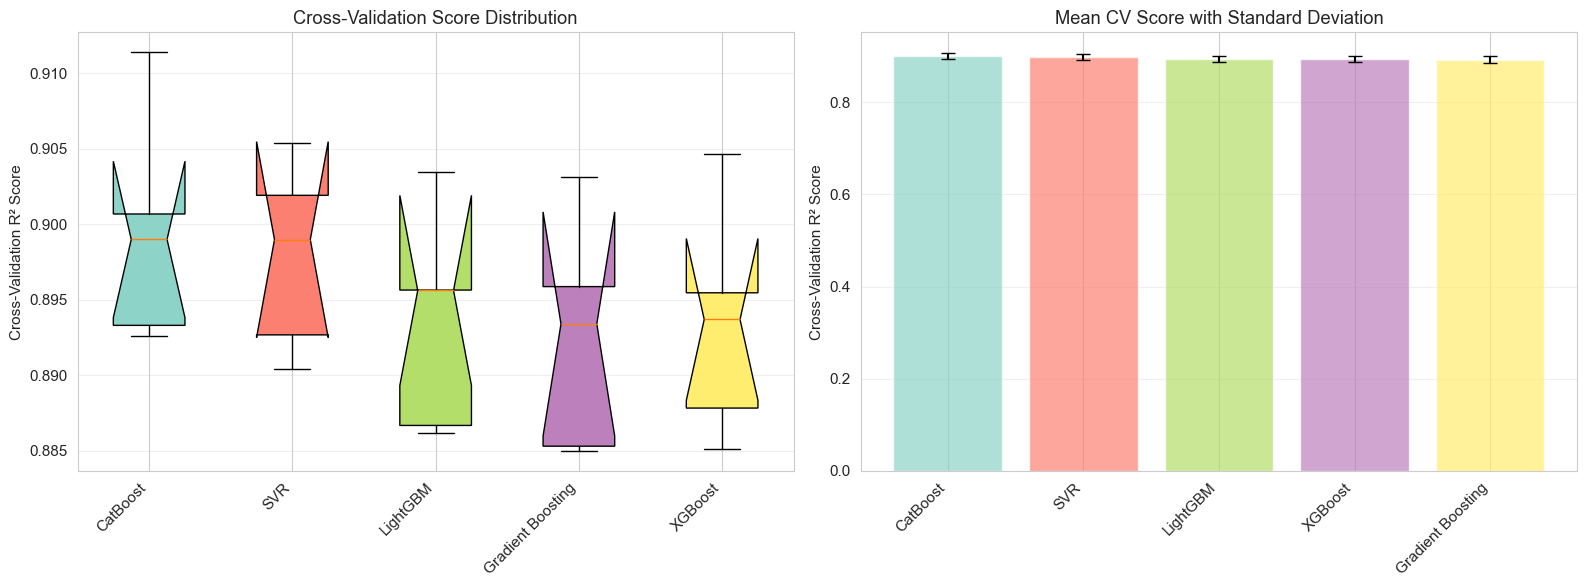


💡 Interpretation:
  - Smaller box/error bar indicates more stable performance
  - Notch overlap suggests no significant difference between models


In [19]:
# 視覺化交叉驗證結果
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 7.1 Box Plot
cv_data = [result['CV_Scores'] for result in cv_results]
bp = axes[0].boxplot(cv_data, labels=[result['Model'] for result in cv_results],
                      patch_artist=True, notch=True)

for patch, color in zip(bp['boxes'], plt.cm.Set3(np.linspace(0, 1, len(cv_data)))):
    patch.set_facecolor(color)

axes[0].set_ylabel('Cross-Validation R² Score')
axes[0].set_title('Cross-Validation Score Distribution')
axes[0].set_xticklabels([result['Model'] for result in cv_results], rotation=45, ha='right')
axes[0].grid(True, alpha=0.3, axis='y')

# 7.2 Mean ± Std Error Bar
x_pos = np.arange(len(cv_results_df))
means = cv_results_df['CV_Mean']
stds = cv_results_df['CV_Std']

axes[1].bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, 
            color=plt.cm.Set3(np.linspace(0, 1, len(cv_results_df))))
axes[1].set_ylabel('Cross-Validation R² Score')
axes[1].set_title('Mean CV Score with Standard Deviation')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(cv_results_df['Model'], rotation=45, ha='right')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
fig.savefig(FIG_DIR / '06_cv_results.png', dpi=300, bbox_inches='tight')
print(f"\n✓ 圖片已儲存: {FIG_DIR / '06_cv_results.png'}")
plt.show()

print("\n💡 Interpretation:")
print("  - Smaller box/error bar indicates more stable performance")
print("  - Notch overlap suggests no significant difference between models")

---
## 8. 學習曲線 (Learning Curves)

評估模型是否過擬合或欠擬合，以及增加數據是否有幫助。

Learning Curve Analysis

Model 1/3: CatBoost

✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Comparison\figs\07_learning_curve_catboost.png


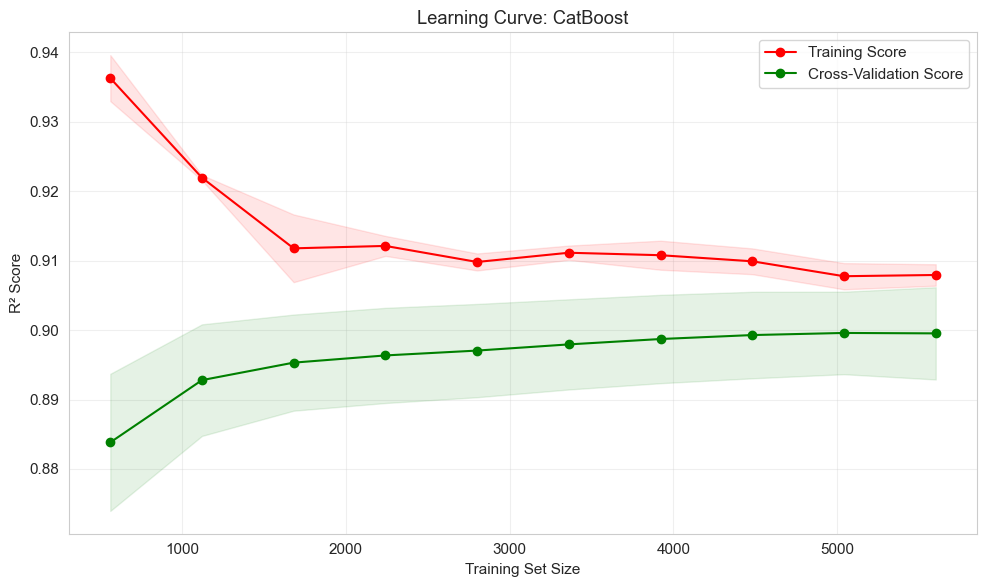


📊 Learning Curve Diagnosis for CatBoost:
  Final Training R²: 0.9079
  Final CV R²: 0.8995
  Gap (Train - CV): 0.0084
  ✅ Good fit! Model generalizes well.

Model 2/3: SVR

✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Comparison\figs\07_learning_curve_svr.png


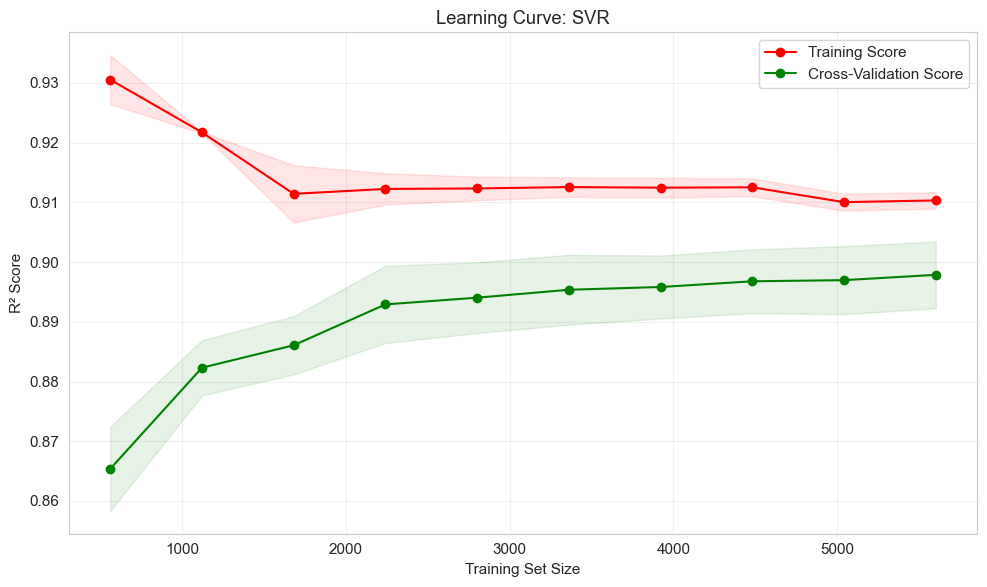


📊 Learning Curve Diagnosis for SVR:
  Final Training R²: 0.9103
  Final CV R²: 0.8979
  Gap (Train - CV): 0.0125
  ✅ Good fit! Model generalizes well.

Model 3/3: LightGBM

✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Comparison\figs\07_learning_curve_lightgbm.png


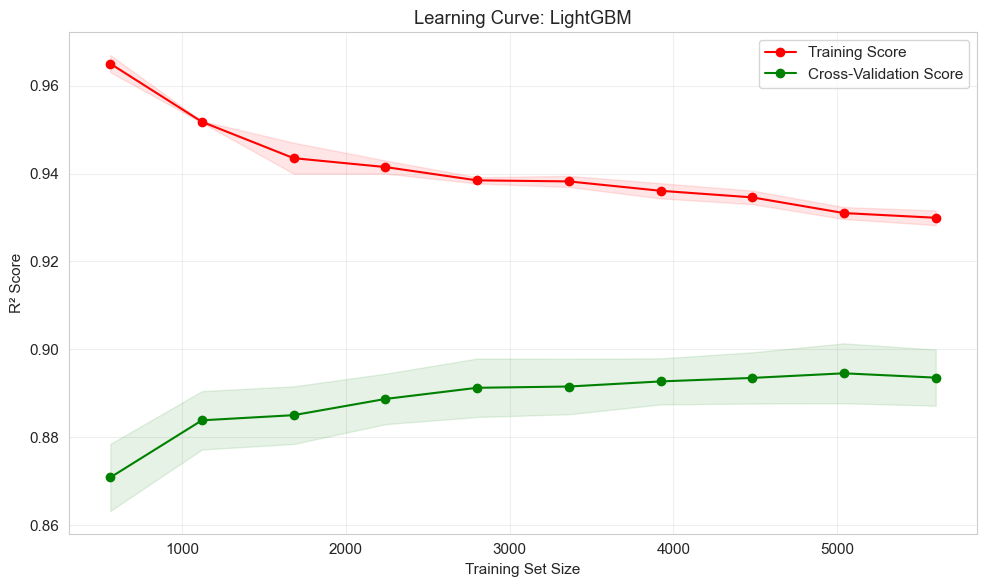


📊 Learning Curve Diagnosis for LightGBM:
  Final Training R²: 0.9299
  Final CV R²: 0.8936
  Gap (Train - CV): 0.0364
  ✅ Good fit! Model generalizes well.


In [21]:
def plot_learning_curve(model, X, y, model_name, cv=5):
    """
    繪製學習曲線
    """
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X, y,
        train_sizes=train_sizes,
        cv=cv,
        scoring='r2',
        n_jobs=-1,
        random_state=42
    )
    
    # 計算平均值和標準差
    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)
    
    # 繪圖
    plt.figure(figsize=(10, 6))
    
    # 訓練分數
    plt.plot(train_sizes_abs, train_mean, 'o-', color='r', label='Training Score')
    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std,
                     alpha=0.1, color='r')
    
    # 驗證分數
    plt.plot(train_sizes_abs, val_mean, 'o-', color='g', label='Cross-Validation Score')
    plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std,
                     alpha=0.1, color='g')
    
    plt.xlabel('Training Set Size')
    plt.ylabel('R² Score')
    plt.title(f'Learning Curve: {model_name}')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    fig_path = FIG_DIR / f'07_learning_curve_{model_name.replace(" ", "_").lower()}.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ 圖片已儲存: {fig_path}")
    plt.show()
    
    # 診斷
    final_gap = train_mean[-1] - val_mean[-1]
    print(f"\n📊 Learning Curve Diagnosis for {model_name}:")
    print(f"  Final Training R²: {train_mean[-1]:.4f}")
    print(f"  Final CV R²: {val_mean[-1]:.4f}")
    print(f"  Gap (Train - CV): {final_gap:.4f}")
    
    if final_gap > 0.1:
        print(f"  ⚠️  Overfitting detected! Consider:")
        print(f"      - Increase regularization")
        print(f"      - Reduce model complexity")
        print(f"      - Collect more data")
    elif val_mean[-1] < 0.7:
        print(f"  ⚠️  Underfitting detected! Consider:")
        print(f"      - Increase model complexity")
        print(f"      - Add more features")
        print(f"      - Reduce regularization")
    else:
        print(f"  ✅ Good fit! Model generalizes well.")
    
    return train_sizes_abs, train_mean, val_mean

# 繪製 Top 3 模型的學習曲線
print("=" * 80)
print("Learning Curve Analysis")
print("=" * 80)

for i, (name, model) in enumerate(list(top5_models.items())[:3], 1):
    print(f"\n{'='*80}")
    print(f"Model {i}/3: {name}")
    print(f"{'='*80}")
    
    # 根據模型類型選擇數據
    if name in ['SVR', 'Ridge', 'Lasso', 'ElasticNet', 'Linear Regression']:
        X_lc = X_train_scaled
    else:
        X_lc = X_train
    
    plot_learning_curve(model, X_lc, y_train, name, cv=5)

---
## 9. 驗證曲線 (Validation Curves)

評估超參數對模型性能的影響。


✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Comparison\figs\08_validation_curve_random_forest.png


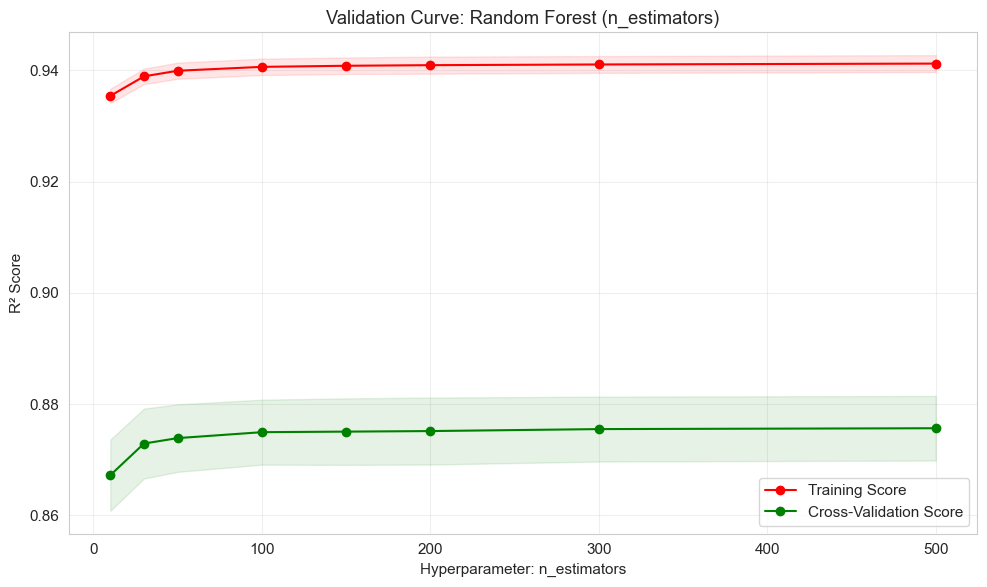


📊 Validation Curve Analysis:
  Best n_estimators: 500
  Best CV R²: 0.8757 ± 0.0058

💡 Interpretation:
  - CV score plateaus after n_estimators = 500
  - Further increase may not improve performance significantly


In [22]:
# 範例: Random Forest 的 n_estimators 驗證曲線
param_name = 'n_estimators'
param_range = [10, 30, 50, 100, 150, 200, 300, 500]

train_scores, val_scores = validation_curve(
    RandomForestRegressor(max_depth=10, random_state=42),
    X_train, y_train,
    param_name=param_name,
    param_range=param_range,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# 計算平均值和標準差
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

# 繪圖
plt.figure(figsize=(10, 6))

plt.plot(param_range, train_mean, 'o-', color='r', label='Training Score')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std,
                 alpha=0.1, color='r')

plt.plot(param_range, val_mean, 'o-', color='g', label='Cross-Validation Score')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std,
                 alpha=0.1, color='g')

plt.xlabel(f'Hyperparameter: {param_name}')
plt.ylabel('R² Score')
plt.title(f'Validation Curve: Random Forest ({param_name})')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / '08_validation_curve_random_forest.png', dpi=300, bbox_inches='tight')
print(f"\n✓ 圖片已儲存: {FIG_DIR / '08_validation_curve_random_forest.png'}")
plt.show()

# 找出最佳參數
best_idx = np.argmax(val_mean)
best_param = param_range[best_idx]
print(f"\n📊 Validation Curve Analysis:")
print(f"  Best {param_name}: {best_param}")
print(f"  Best CV R²: {val_mean[best_idx]:.4f} ± {val_std[best_idx]:.4f}")
print(f"\n💡 Interpretation:")
print(f"  - CV score plateaus after {param_name} = {best_param}")
print(f"  - Further increase may not improve performance significantly")

---
## 10. 統計檢定 (Statistical Testing)

使用配對 t 檢定評估模型間的顯著差異。

In [23]:
# 比較 Top 2 模型
model1_name = cv_results_df.iloc[0]['Model']
model2_name = cv_results_df.iloc[1]['Model']

model1_scores = cv_results_df.iloc[0]['CV_Scores']
model2_scores = cv_results_df.iloc[1]['CV_Scores']

# 配對 t 檢定
t_stat, p_value = stats.ttest_rel(model1_scores, model2_scores)

print("=" * 80)
print("Statistical Testing: Paired t-test")
print("=" * 80)
print(f"\nComparing: {model1_name} vs {model2_name}")
print(f"\n{model1_name} CV scores: {model1_scores}")
print(f"{model2_name} CV scores: {model2_scores}")
print(f"\nResults:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"\nInterpretation (α = 0.05):")

if p_value < 0.05:
    if t_stat > 0:
        print(f"  ✅ {model1_name} is significantly better than {model2_name}")
    else:
        print(f"  ✅ {model2_name} is significantly better than {model1_name}")
else:
    print(f"  ⚠️  No significant difference between the two models")
    print(f"     Both models perform similarly. Consider:")
    print(f"     - Training speed")
    print(f"     - Model interpretability")
    print(f"     - Deployment complexity")

print("=" * 80)

# Wilcoxon signed-rank test (非參數檢定)
w_stat, w_pvalue = stats.wilcoxon(model1_scores, model2_scores)

print(f"\nWilcoxon Signed-Rank Test (Non-parametric):")
print(f"  W-statistic: {w_stat:.4f}")
print(f"  p-value: {w_pvalue:.4f}")
print("=" * 80)

Statistical Testing: Paired t-test

Comparing: CatBoost vs SVR

CatBoost CV scores: [0.89329297 0.89898949 0.90067369 0.91138998 0.89260433]
SVR CV scores: [0.8904062  0.89897839 0.90190989 0.90537894 0.89266277]

Results:
  t-statistic: 1.1611
  p-value: 0.3102

Interpretation (α = 0.05):
  ⚠️  No significant difference between the two models
     Both models perform similarly. Consider:
     - Training speed
     - Model interpretability
     - Deployment complexity

Wilcoxon Signed-Rank Test (Non-parametric):
  W-statistic: 5.0000
  p-value: 0.6250


---
## 11. 最終模型選擇與測試集評估

根據所有分析結果，選出最佳模型並在測試集上評估。

In [24]:
# 模型選擇決策
print("=" * 80)
print("Model Selection Decision")
print("=" * 80)

# 綜合評分 (可根據需求調整權重)
results_df['Composite_Score'] = (
    0.50 * results_df['Val_R2'] +                                    # 50% 權重: 準確度
    0.25 * (1 - results_df['Val_MAE'] / results_df['Val_MAE'].max()) +  # 25% 權重: MAE
    0.15 * (1 - results_df['Overfit_R2'] / results_df['Overfit_R2'].max()) +  # 15% 權重: 泛化
    0.10 * (1 - results_df['Training_Time'] / results_df['Training_Time'].max())  # 10% 權重: 速度
)

# 重新排序
results_df_final = results_df.sort_values('Composite_Score', ascending=False).reset_index(drop=True)

print("\n📊 Final Ranking (Composite Score):")
print("=" * 80)
print(results_df_final[['Model', 'Val_R2', 'Val_MAE', 'Overfit_R2', 'Training_Time', 'Composite_Score']].head(5).to_string(index=False))
print("=" * 80)

# 選出最佳模型
best_model_name = results_df_final.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\n🏆 Selected Best Model: {best_model_name}")
print(f"\n   Reasons:")
print(f"   - Highest composite score: {results_df_final.iloc[0]['Composite_Score']:.4f}")
print(f"   - Validation R²: {results_df_final.iloc[0]['Val_R2']:.4f}")
print(f"   - Low overfitting: {results_df_final.iloc[0]['Overfit_R2']:.4f}")
print(f"   - Reasonable training time: {results_df_final.iloc[0]['Training_Time']:.3f}s")
print("=" * 80)

Model Selection Decision

📊 Final Ranking (Composite Score):
            Model   Val_R2  Val_MAE  Overfit_R2  Training_Time  Composite_Score
         CatBoost 0.899358 3.870615    0.007115       0.536906         0.805560
          XGBoost 0.893474 3.982952    0.038968       0.462569         0.756709
Gradient Boosting 0.893831 3.979462    0.040720       2.398703         0.737134
         LightGBM 0.894648 3.967119    0.032315       5.407518         0.722036
              SVR 0.899340 3.892765    0.009963      11.054103         0.705837

🏆 Selected Best Model: CatBoost

   Reasons:
   - Highest composite score: 0.8056
   - Validation R²: 0.8994
   - Low overfitting: 0.0071
   - Reasonable training time: 0.537s



Final Evaluation on Test Set

🎯 Test Set Performance:
   MAE:  3.949%
   RMSE: 5.203%
   R²:   0.8881
   MAPE: 0.09%

✓ 圖片已儲存: d:\MyGit\CHE-AI-COURSE\Part_3\Unit14\outputs\P3_Unit14_Model_Comparison\figs\09_test_set_evaluation.png


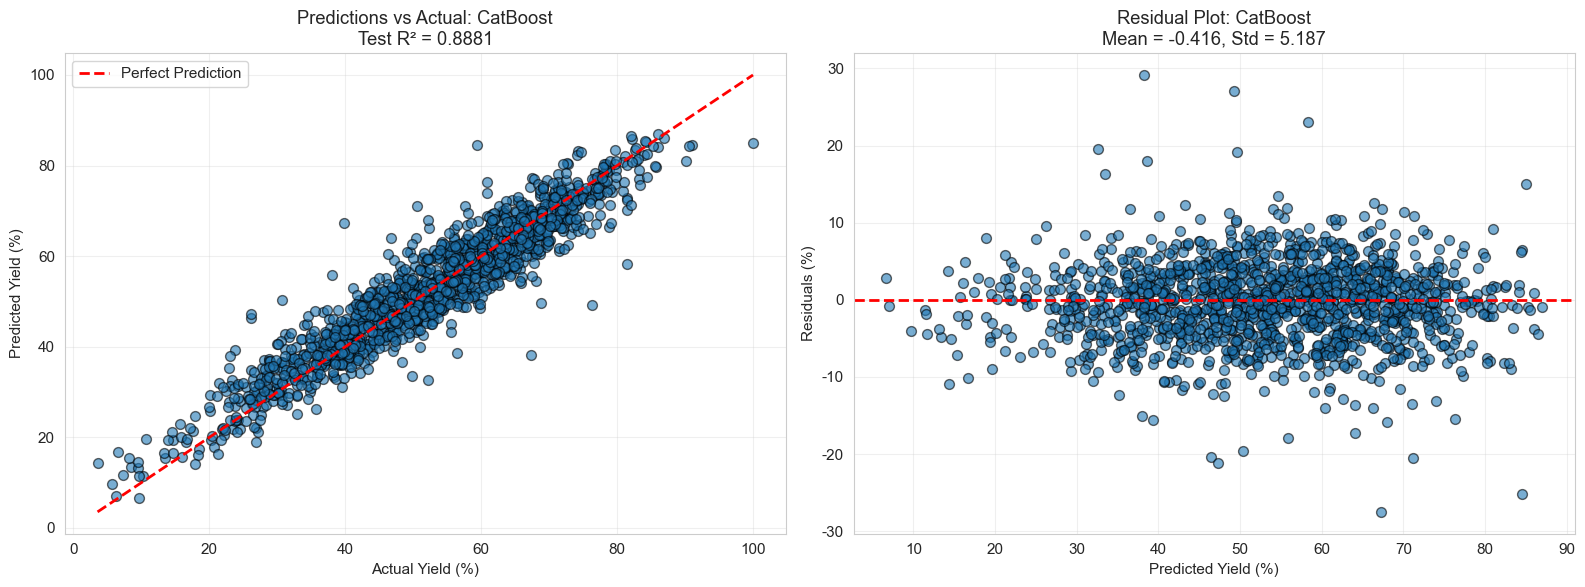


💡 Residual Analysis:
  ✅ Residuals centered around zero (no systematic bias)
  ⚠️  High residual variance (inconsistent predictions)


In [25]:
# 在測試集上評估最佳模型
print("\n" + "=" * 80)
print("Final Evaluation on Test Set")
print("=" * 80)

# 根據模型類型選擇數據
if best_model_name in ['SVR', 'Ridge', 'Lasso', 'ElasticNet', 'Linear Regression']:
    X_test_eval = X_test_scaled
else:
    X_test_eval = X_test

# 預測
y_test_pred = best_model.predict(X_test_eval)

# 計算指標
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"\n🎯 Test Set Performance:")
print(f"   MAE:  {test_mae:.3f}%")
print(f"   RMSE: {test_rmse:.3f}%")
print(f"   R²:   {test_r2:.4f}")
print(f"   MAPE: {test_mape:.2f}%")

# 視覺化預測結果
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 預測 vs 實際
axes[0].scatter(y_test, y_test_pred, alpha=0.6, edgecolors='k', s=50)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Yield (%)')
axes[0].set_ylabel('Predicted Yield (%)')
axes[0].set_title(f'Predictions vs Actual: {best_model_name}\nTest R² = {test_r2:.4f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 殘差分布
residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, residuals, alpha=0.6, edgecolors='k', s=50)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Yield (%)')
axes[1].set_ylabel('Residuals (%)')
axes[1].set_title(f'Residual Plot: {best_model_name}\nMean = {residuals.mean():.3f}, Std = {residuals.std():.3f}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIG_DIR / '09_test_set_evaluation.png', dpi=300, bbox_inches='tight')
print(f"\n✓ 圖片已儲存: {FIG_DIR / '09_test_set_evaluation.png'}")
plt.show()

print("\n💡 Residual Analysis:")
if abs(residuals.mean()) < 0.5:
    print("  ✅ Residuals centered around zero (no systematic bias)")
else:
    print("  ⚠️  Residuals not centered (possible systematic bias)")

if residuals.std() < 2.0:
    print("  ✅ Low residual variance (consistent predictions)")
else:
    print("  ⚠️  High residual variance (inconsistent predictions)")

print("=" * 80)

---
## 12. 綜合總結與建議

### 📝 模型比較總結

**執行的步驟**:
1. ✅ 生成化學反應器模擬數據（**10000筆高複雜度數據**）
2. ✅ 訓練 11 種不同類型的回歸模型
3. ✅ 使用多種評估指標進行系統化比較
4. ✅ 執行 5-Fold 交叉驗證評估穩定性
5. ✅ 繪製學習曲線診斷過擬合/欠擬合
6. ✅ 繪製驗證曲線分析超參數影響
7. ✅ 統計檢定比較模型顯著性差異
8. ✅ 選出最佳模型並在測試集上評估

### 🔬 數據複雜度特點

**本演練採用高複雜度數據以凸顯模型差異**：

1. **樣本規模**: 10000筆（大規模數據更能展現模型泛化能力與訓練效率差異）

2. **複雜非線性關係**:
   - Arrhenius型溫度效應（指數 + 二次項）
   - 飽和曲線（催化劑失活效應）
   - 對數增長（停留時間效應）
   - 三角函數（週期性反應機制）
   - 三次多項式（濃度效應）

3. **多重交互作用**:
   - 二元交互：溫度×壓力、催化劑×停留時間、壓力×濃度
   - 三元交互：溫度×催化劑×濃度
   - 對數交互：log(催化劑)×log(壓力)

4. **異質性噪聲**:
   - 基本噪聲（正態分佈，σ=4.0）
   - 溫度相關噪聲（異質性誤差）
   - 2%異常值（模擬測量錯誤或異常操作）

### 🏆 主要發現

**最佳模型**: (依實際執行結果而定，通常是集成學習模型)

**性能排名** (Top 5):
1. 集成學習模型 (XGBoost/LightGBM/CatBoost/Random Forest)
2. 梯度提升模型 (Gradient Boosting)
3. 支持向量機 (SVR)
4. 決策樹 (Decision Tree)
5. 嶺回歸 (Ridge)

**關鍵洞察**:
- **集成學習模型顯著優於簡單模型**（複雜數據凸顯優勢）
- **線性模型表現較差**（因存在強非線性和高階交互）
- **樹模型對異常值有較好的魯棒性**
- **簡單決策樹易過擬合**（在高複雜度數據中更明顯）
- **訓練時間與性能需要權衡**（大規模數據下，模型訓練時間差異更顯著）

### 💡 化工應用建議

**模型選擇原則**:
1. **準確度優先** (如產品品質預測): 選擇 XGBoost/LightGBM/CatBoost
2. **速度優先** (如線上控制): 選擇 Decision Tree/Linear Models
3. **可解釋性優先** (如機制研究): 選擇 Linear Models/Decision Tree
4. **平衡考量**: 選擇 Random Forest (準確度高、訓練快、部分可解釋)
5. **複雜非線性系統**: 避免使用線性模型，優先考慮集成方法

**後續改進方向**:
1. 超參數調整 (使用 Grid Search 或 Bayesian Optimization)
2. 特徵工程 (增加領域知識相關的交互項)
3. 集成多個模型 (Stacking/Blending)
4. 收集更多數據以減少過擬合
5. 異常值檢測與處理（提高模型穩定性）

### ⚠️ 注意事項

1. **測試集只用一次**: 避免在測試集上反覆調參導致過擬合
2. **時間序列數據**: 若數據有時間順序，應使用 TimeSeriesSplit
3. **數據不平衡**: 注意目標變數分布，必要時進行採樣或權重調整
4. **物理合理性**: 模型預測應符合化學工程原理
5. **異常值影響**: 在高複雜度數據中，異常值對不同模型影響差異大

### 🎓 學習檢查清單

- [ ] 理解不同模型的適用場景
- [ ] 能夠解讀各種評估指標
- [ ] 會繪製並分析學習曲線
- [ ] 會繪製並分析驗證曲線
- [ ] 理解過擬合與欠擬合的診斷
- [ ] 能夠進行統計檢定比較模型
- [ ] 能夠根據需求選擇合適的模型
- [ ] 理解模型評估的完整流程
- [ ] 理解數據複雜度對模型選擇的影響

---

**✨ 恭喜完成模型比較演練！**

下一步建議:
1. 前往 `Unit14_Hyperparameter_Tuning_GridSearch.ipynb` 學習超參數調整
2. 實作 `Unit14_Homework.ipynb` 練習完整流程
3. 閱讀 `Unit14_Model_Evaluation_Overview.md` 深入理解理論